<h1> <strong> Titanic Competition Kaggle </strong> </h1>
<hr>

This is the notebook to develop the competition related to <a href = "https://www.kaggle.com/competitions/titanic/data">Titanic</a> competiton. First I load the libraries requered to implemented.

<h2> <strong> Libraries </strong> </strong> </h2>
<hr>

The next are the libraries implemented to the challenge:
<ul>
<li> pandas 
<li> os
<li> numpy
<li> ptitprince
<li> matplotlib.pyplot
</ul>

In [1]:
import pandas as pd
import os
import numpy as np
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

<h2> <strong> Databases </strong> </h2>
<hr>

Now we must load the data to work. In this case we have two databases:
<ul>
<li> test.csv with this, we prove the models implemented.
<li> train.csv has all of the registers to train the models that i want to use.
</ul>

In [2]:
# os.chdir(path=os.getcwd() + "\\Titanic_Competition_Kaggle")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

<h2> <strong> Missing Data </h2> </strong>
<hr>

First we must review if the data has empy values. For this, we review each variable to see this:

In [3]:
colums_with_na = []
for i in train.columns:
    if train[i].isna().any():
        colums_with_na.append(i)

colums_with_na

['Age', 'Cabin', 'Embarked']

I found 3 variables with na values. For this variables, we want to count how many na's has each variable:

In [4]:
{"Age": sum(train["Age"].isna()),
 "Cabin": sum(train["Cabin"].isna()),
 "Embarked": sum(train["Embarked"].isna())}

{'Age': 177, 'Cabin': 687, 'Embarked': 2}

I have seen that <i> Age </i> has 177 na values; <i> Cabin </i> has 687 na values and <i> Embarked </i> has 2 values. With this, I decided to drop the variable <i> Cabin </i> because has many na; with <i> Age </i> I'm going to imput the na values and also drop the 2 rows of <i> Embarked </i>.

In [5]:
train.drop(["Cabin","PassengerId", "Name", "Ticket"], axis=1, inplace=True)

Finally drop the empy rows of <i> Embarked </i>:

In [6]:
train = train.loc[~train["Embarked"].isna(), :]

In [7]:
train_imput_data = (
    train.
    groupby(["Survived", "Pclass", "Sex", "Embarked"]).
    agg(
        Mean_Age = ("Age", lambda x: np.round(np.nanmean(x), 0))
    )
)

train_imput_data["Mean_Age"] = train_imput_data["Mean_Age"].fillna(np.nanmean(train_imput_data.Mean_Age))
train_imput_data = train_imput_data.astype(int)

train = (
    train_imput_data.
    join(
        train.
        set_index(["Survived", "Pclass", "Sex", "Embarked"]),
        how='right'
    ).
    reset_index()
    )

train["Age"] = train["Age"].fillna(train["Mean_Age"])
train["Age"] = train["Age"].fillna(np.nanmean(train["Mean_Age"]))
train.drop(["Mean_Age"], axis=1, inplace=True)

With the last code, we can identify the types of each column, and with this, change to the correct type.

In [8]:
test = test.astype({"Sex": "category", "Pclass":"category", "Embarked": "category"})
train = train.astype({"Sex": "category", "Pclass":"category", "Embarked": "category", "Survived": "category"})

Finally, in the test data also has the empy values. For this, we fill the nan with te group mean by Pclass, Sex and Embarked.

In [9]:
Age_test = (
    test.
    groupby(["Pclass", "Sex", "Embarked"]).
    agg(
        Media_Age = ("Age", "mean")
    )
)

Age_test.fillna(np.round(np.nanmean(Age_test["Media_Age"]), 0), inplace=True)

Mean_test = (
    test.
    set_index(["Pclass", "Sex", "Embarked"]).
    join(
        Age_test
    ).
    reset_index().
    drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1))

test["Age"] = test["Age"].fillna(Mean_test["Media_Age"])
test["Fare"].fillna(np.nanmean(test["Fare"]), inplace=True)

test_PassengerId = test["PassengerId"]
test.drop(["Cabin","PassengerId", "Name", "Ticket"], axis=1, inplace=True)

<h2> <strong> Exploratory Analysis </h2> </strong>
<hr>

After load the databases, I do a exploratory analysis. Also we modify the variables acording they nature.

In [10]:
train.describe(include='all').fillna(0)

,Survived,Pclass,Sex,Embarked,Age,SibSp,Parch,Fare
count,889.0,889.0,889,889,889.000000,889.000000,889.000000,889.000000
unique,2.0,3.0,2,3,0.000000,0.000000,0.000000,0.000000
top,0.0,3.0,male,S,0.000000,0.000000,0.000000,0.000000
freq,549.0,491.0,577,644,0.000000,0.000000,0.000000,0.000000
mean,0.0,0.0,0,0,29.246535,0.524184,0.382452,32.096681
std,0.0,0.0,0,0,13.416390,1.103705,0.806761,49.697504
min,0.0,0.0,0,0,0.420000,0.000000,0.000000,0.000000
25%,0.0,0.0,0,0,21.000000,0.000000,0.000000,7.895800
50%,0.0,0.0,0,0,28.000000,0.000000,0.000000,14.454200
75%,0.0,0.0,0,0,36.000000,1.000000,0.000000,31.000000


This table is not many informative, for this, we want to see the result using variables to group the data.

In [11]:
def descriptive_cross(var, dataframe = train):
    """This function calculate the mean of the quantitative variables
    given a categorical(s) variable(s). This is only for this project
    
    var: This can be a string given the name of the variable or a list of
    categorical variables
    
    dataframe: This is the dataframe that we are used for train"""

    result = (
        dataframe.
        groupby(var, observed=True).
        agg(
            Age = ("Age", lambda x: np.round(np.mean(x), 2)),
            SibSp = ("SibSp", lambda x: np.round(np.mean(x),2)),
            Parch = ("Parch", lambda x: np.round(np.mean(x),2)),
            Fare = ("Fare", lambda x: np.round(np.mean(x),2))
    ).
    reset_index()
    )

    return result

Now, for example, if we want to see the comparative with sex, survival, o Pclass, we can use this:

In [12]:
descriptive_cross(var = ["Survived","Sex", "Pclass"])

,Survived,Sex,Pclass,Age,SibSp,Parch,Fare
0,0,female,1,25.67,0.67,1.33,110.60
1,0,female,2,36.00,0.50,0.17,18.25
2,0,female,3,23.96,1.29,1.10,19.77
3,0,male,1,44.54,0.27,0.26,62.89
4,0,male,2,33.31,0.31,0.14,19.49
5,0,male,3,27.31,0.52,0.21,12.20
6,1,female,1,34.62,0.56,0.44,106.56
7,1,female,2,28.12,0.49,0.64,22.29
8,1,female,3,18.62,0.50,0.50,12.46
9,1,male,1,36.22,0.38,0.31,74.64


We found that the female people survived more than male, and dead more male that female, also, the Fare of the female that survived was the highest mean to the others groups. Finally, the female group that had Pclass equals to 1 and survived, was the group with more integers.

<h3> <strong> Sex Variable Analysis </h3> </strong>
<hr>

Now we analyze the <i> Sex </i> variable, cross first with the numerical variables, and then with the categorical.

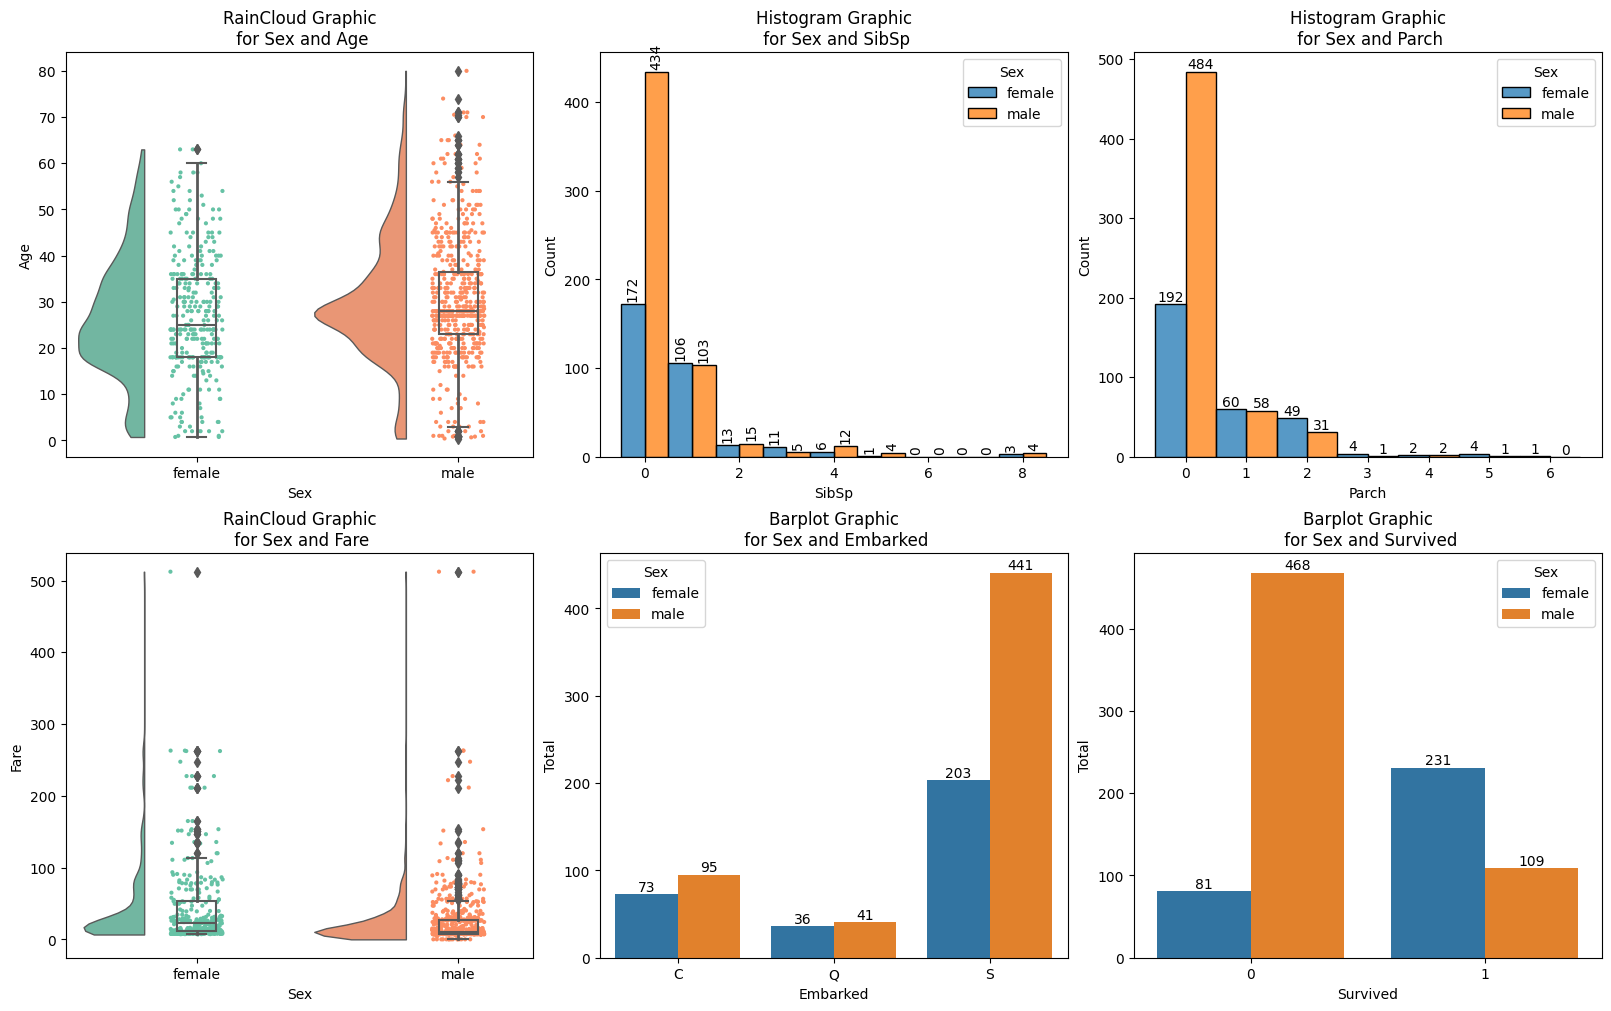

In [13]:
fig = plt.figure(layout="constrained", figsize=(16, 10))
ax_dict = fig.subplot_mosaic([
    ["A","B", "C"],
    ["D", "E", "F"]])

pt.RainCloud(
    data=train,
    x = "Sex",
    y = "Age",
    ax = ax_dict['A']
)

sns.histplot(
    data=train,
    x = "SibSp",
    hue="Sex",
    multiple = "dodge",
    discrete=True,
    ax=ax_dict["B"]
)

sns.histplot(
    data=train,
    x = "Parch",
    hue="Sex",
    multiple = "dodge",
    discrete=True,
    ax=ax_dict["C"]
)

pt.RainCloud(
    data=train,
    x = "Sex",
    y = "Fare",
    ax = ax_dict['D']
)

sns.barplot(
    data=(train.
          groupby(["Embarked", "Sex"], observed=False).
          agg(
             Total = ("Sex", "size")
          ).reset_index()),
    x = "Embarked",
    y = "Total",
    hue="Sex",
    ax = ax_dict["E"]
)

sns.barplot(
    data=(train.
          groupby(["Survived", "Sex"], observed=False).
          agg(
             Total = ("Sex", "size")
          ).reset_index()),
    x = "Survived",
    y = "Total",
    hue="Sex",
    ax = ax_dict["F"]
)

ax_dict['A'].set_title("RainCloud Graphic\n for Sex and Age")
ax_dict['B'].set_title("Histogram Graphic\n for Sex and SibSp")
ax_dict['C'].set_title("Histogram Graphic\n for Sex and Parch")
ax_dict['D'].set_title("RainCloud Graphic\n for Sex and Fare")
ax_dict['E'].set_title("Barplot Graphic\n for Sex and Embarked")
ax_dict['F'].set_title("Barplot Graphic\n for Sex and Survived")

for i in ax_dict["B"].containers:
    ax_dict["B"].bar_label(i, rotation = "vertical", padding=2)

for i in ax_dict["C"].containers:
    ax_dict["C"].bar_label(i)

for i in ax_dict["E"].containers:
    ax_dict["E"].bar_label(i)

for i in ax_dict["F"].containers:
    ax_dict["F"].bar_label(i)

plt.show()



<h2> <strong> Survived Analysis </strong> </h2>
<hr>

Now we want to analyze the _Survived_ variable, that is the main objetive to predict. We put a new descriptive graphics to see the relationship with others variables.

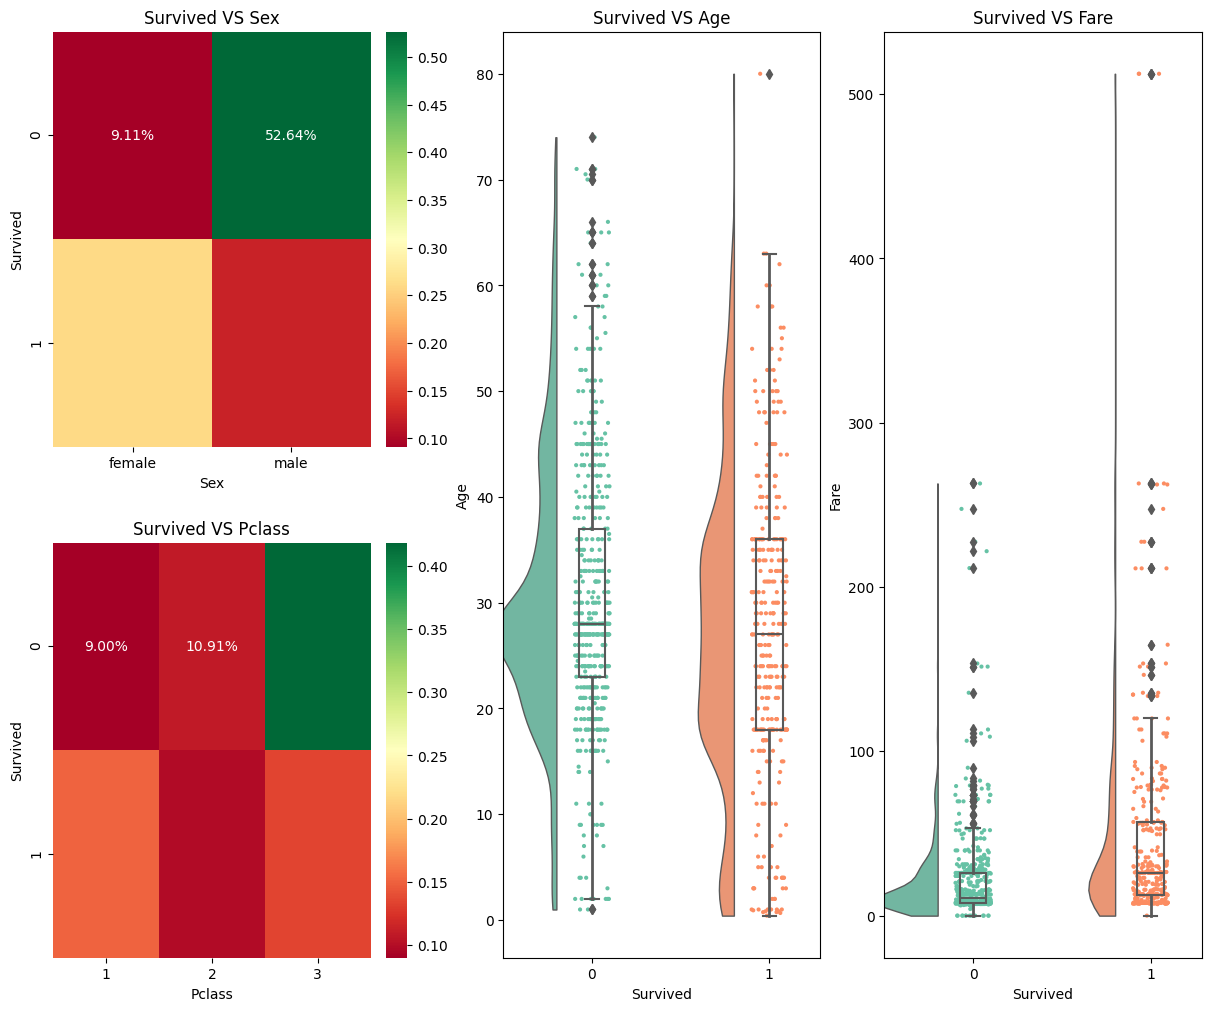

In [14]:
fig = plt.figure(layout="constrained", figsize=(12, 10))
ax_dict2 = fig.subplot_mosaic(
    mosaic=[["A", "B", "C"],
     ["D", "B", "C"]]    
)

SurvivedxSex = (
    train.
    groupby(["Survived", "Sex"]).
    agg(
        Count = ("Survived", "count")
    ).
    transform(
        {"Count": lambda x: np.round(x/sum(x), 4)}
    ).
    reset_index()
    ).pivot(
index = "Survived",
columns = "Sex",
values = "Count")

sns.heatmap(
    data=SurvivedxSex,
    annot=SurvivedxSex.values,
    cmap='RdYlGn',
    fmt = ".2%",
    ax = ax_dict2["A"]
)

SurvivedxPclass = (
    train.
    groupby(["Survived", "Pclass"]).
    agg(
        Count = ("Survived", "count")
    ).
    transform(
        {"Count": lambda x: np.round(x/sum(x), 4)}
    ).
    reset_index()
    ).pivot(
index = "Survived",
columns = "Pclass",
values = "Count")

sns.heatmap(
    data=SurvivedxPclass,
    annot=SurvivedxPclass.values,
    fmt=".2%",
    cmap="RdYlGn",
    ax = ax_dict2["D"]
)


pt.RainCloud(
    data=train,
    y="Age",
    x="Survived",
    ax=ax_dict2["B"]
)

pt.RainCloud(
    data=train,
    x = "Survived",
    y = "Fare",
    ax = ax_dict2["C"]
)

ax_dict2["A"].set_title("Survived VS Sex")
ax_dict2["D"].set_title("Survived VS Pclass")
ax_dict2["B"].set_title("Survived VS Age")
ax_dict2["C"].set_title("Survived VS Fare")
plt.show()


We found that more percentaje of male not survived that the female population. Also, the Pclass 3 had more percentaje of no survived. In terms of age, the behavior was similar between the group that Survived and no. 

In the case of Fare, exist a small difference between the group of survived and no. In this case, I found that the values of the people that survived is greater than the people that not survived, but the difference isn't bigger.

<h1> <strong> Predictive Models </strong> </h1>
<hr>

Now I'm going to apply different models to predict the Survive of a people according to the characteristics. The main objetive is predict correctly the survived of the passenger accordig tho the variables.

In [15]:
train_x = pd.get_dummies(train.drop(["Survived"], axis=1))
train_y = train["Survived"]

<strong>  <h2> Logistic Regression </strong> </h2>
<hr>

The first model that I want to apply is the <strong> Logistic Regression </strong>. This model is used to predict the probability be a class according to the characteristics. First I train the model with the data, and then, predict the result with the test data.

In [16]:
LM_1 = LogisticRegression().fit(train_x, train_y)

The result was this. For <a url = "https://www.kaggle.com"> Kaggle </a> requeried a .csv value to obtain the result of the model. For this, create a folder to storage the result, and a file called <i> Logistic_Regression.csv </i> to upload the result.

In [17]:
pd.DataFrame(
    {"PassengerId":test_PassengerId,
     "Survived":LM_1.predict(pd.get_dummies(test))}
).to_csv(
    "Result_Models\Logistic_Regression.csv",
    sep=",",
    index=False)

<center> <img src = "Kaggle_Results\Logistic_Regression.png" width="600" height="300"> </center>

The result obtained for this model is **76.794%** of precision.